# Flocking model

Continuous-space agent interactions. [Source](https://juliadynamics.github.io/Agents.jl/stable/examples/flock/)

Each agent follows three simple rules:

+ maintain a minimum distance from other birds to avoid collision
+ fly towards the average position of neighbors
+ fly in the average direction of neighbors

In [1]:
using Agents
using Random
using LinearAlgebra
using Base64
using CairoMakie
CairoMakie.activate!(px_per_unit = 1.0)

The helper function is adapted from `Agents.abmvideo` and correctly displays animations in Jupyter notebooks

In [2]:
function abmvio(model;
    dt = 1, framerate = 30, frames = 300, title = "", showstep = true,
    figure = (size = (600, 600),), axis = NamedTuple(),
    recordkwargs = (compression = 23, format ="mp4"), kwargs...
)
    # title and steps
    abmtime_obs = Observable(abmtime(model))
    if title ≠ "" && showstep
        t = lift(x -> title*", time = "*string(x), abmtime_obs)
    elseif showstep
        t = lift(x -> "time = "*string(x), abmtime_obs)
    else
        t = title
    end

    axis = (title = t, titlealign = :left, axis...)
    # First frame
    fig, ax, abmobs = abmplot(model; add_controls = false, warn_deprecation = false, figure, axis, kwargs...)
    resize_to_layout!(fig)
    # Animation
    Makie.Record(fig; framerate, recordkwargs...) do io
        for j in 1:frames-1
            recordframe!(io)
            Agents.step!(abmobs, dt)
            abmtime_obs[] = abmtime(model)
        end
        recordframe!(io)
    end
end

abmvio (generic function with 1 method)

This agents has also three properties inherited from ContinuousAgent

+ id : unique identifier
+ pos : XY coordinate
+ vel: XY velocity

In [3]:
@agent struct Bird(ContinuousAgent{2,Float64})
    speed::Float64
    cohere_factor::Float64
    separation::Float64
    separate_factor::Float64
    match_factor::Float64
    visual_distance::Float64
end

Model factory function

In [4]:
function initialize_model(;
    n_birds = 100,
    speed = 1.5,
    cohere_factor = 0.1,
    separation = 2.0,
    separate_factor = 0.25,
    match_factor = 0.04,
    visual_distance = 5.0,
    extent = (100, 100),
    seed = 2024,
)
    space2d = ContinuousSpace(extent; spacing = visual_distance/1.5)
    rng = Random.MersenneTwister(seed)

    model = StandardABM(Bird, space2d; rng, agent_step!, scheduler = Schedulers.Randomly())
    for _ in 1:n_birds
        vel = rand(abmrng(model), SVector{2}) * 2 .- 1
        add_agent!(
            model,
            vel,
            speed,
            cohere_factor,
            separation,
            separate_factor,
            match_factor,
            visual_distance,
        )
    end
    return model
end

initialize_model (generic function with 1 method)

Stepping function

In [5]:
function agent_step!(bird, model)
    # Obtain the ids of neighbors within the bird's visual distance
    neighbor_ids = nearby_ids(bird, model, bird.visual_distance)
    N = 0
    match = separate = cohere = (0.0, 0.0)
    # Calculate behaviour properties based on neighbors
    for id in neighbor_ids
        N += 1
        neighbor = model[id].pos
        heading = get_direction(bird.pos, neighbor, model)

        # `cohere` computes the average position of neighboring birds
        cohere = cohere .+ heading
        if euclidean_distance(bird.pos, neighbor, model) < bird.separation
            # `separate` repels the bird away from neighboring birds
            separate = separate .- heading
        end
        # `match` computes the average trajectory of neighboring birds
        match = match .+ model[id].vel
    end

    N = max(N, 1)
    # Normalise results based on model input and neighbor count
    cohere = cohere ./ N .* bird.cohere_factor
    separate = separate ./ N .* bird.separate_factor
    match = match ./ N .* bird.match_factor
    # Compute velocity based on rules defined above
    bird.vel = (bird.vel .+ cohere .+ separate .+ match) ./ 2
    bird.vel = bird.vel ./ norm(bird.vel)
    # Move bird according to new velocity and speed
    move_agent!(bird, model, bird.speed)
end

agent_step! (generic function with 1 method)

## Visualization

In [6]:
const bird_polygon = Makie.Polygon(Point2f[(-1, -1), (2, 0), (-1, 1)])
function bird_marker(b::Bird)
    φ = atan(b.vel[2], b.vel[1]) ##+ π/2 + π
    rotate_polygon(bird_polygon, φ)
end

bird_marker (generic function with 1 method)

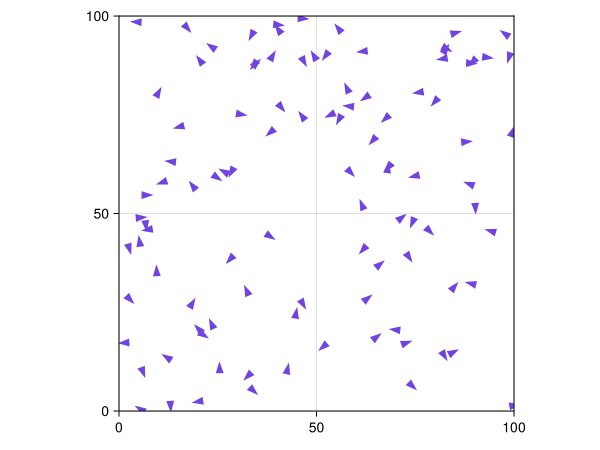

In [7]:
model = initialize_model()
figure, _ = abmplot(model; agent_marker = bird_marker)
figure

Animation

In [8]:
vio = abmvio(
    model;
    agent_marker = bird_marker,
    framerate = 20, frames = 150,
    title = "Flocking",
)
save("flocking.mp4", vio)
vio |> display

Makie.VideoStream(Base.PipeEndpoint(RawFD(4294967295) closed, 0 bytes waiting), Process(setenv(`/home/runner/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin/ffmpeg -y -loglevel quiet -threads 4 -framerate 20 -pixel_format rgb24 -f rawvideo -s:v 600x600 -r 20 -i pipe:0 -vf vflip -profile:v high422 -crf 23 -preset slow -c:v libx264 -pix_fmt yuv420p -an '/tmp/jl_Z1wTwL/##video#228.mp4'`,["JULIA_CI=true", "PATH=/home/runner/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/bin:/home/runner/.julia/artifacts/0ccc8805e5047cf9fbd848c4f7d4c15715aad7c9/bin:/home/runner/.julia/artifacts/96bc7b9ddb319d1a051535c85184aa2bf42dbd8b/bin:/home/runner/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/bin:/home/runner/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/bin:/home/runner/.julia/artifacts/1cf7375e8ec1bbe1219934488737c12237ba2012/bin:/home/runner/.julia/artifacts/aa47becfd7dbea936fcdbe2abc2c5637739026df/bin:/home/runner/.julia/artifacts/00023f2f62a04af7531278ce1a689ff93800ffa1/bin:/home/runner/.julia/artifacts/c951fb23b5652def1dea483af7095a38f3b3cefd/bin:/home/runner/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin:/opt/hostedtoolcache/julia/1.10.6/x64/bin:/opt/hostedtoolcache/Python/3.12.7/x64/bin:/opt/hostedtoolcache/Python/3.12.7/x64:/snap/bin:/home/runner/.local/bin:/opt/pipx_bin:/home/runner/.cargo/bin:/home/runner/.config/composer/vendor/bin:/usr/local/.ghcup/bin:/home/runner/.dotnet/tools:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin", "DOTNET_SKIP_FIRST_TIME_EXPERIENCE=1", "GITHUB_RUN_NUMBER=449", "GITHUB_REF_NAME=main", "RUNNER_ARCH=X64", "STATS_PIP=false", "PERFLOG_LOCATION_SETTING=RUNNER_PERFLOG", "LD_LIBRARY_PATH=/home/runner/.julia/artifacts/f839432e3d2904a5c847b217ef0c0f489377ecc5/lib:/opt/hostedtoolcache/julia/1.10.6/x64/bin/../lib/julia:/home/runner/.julia/artifacts/0803f8d074309498cdf55effdb9c55bc3ef88dde/lib:/home/runner/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/lib:/home/runner/.julia/artifacts/2def0eca464bd6d89ccac85338474402359d4930/lib:/home/runner/.julia/artifacts/d00220164876dea2cb19993200662745eed5e2db/lib:/home/runner/.julia/artifacts/0ccc8805e5047cf9fbd848c4f7d4c15715aad7c9/lib:/home/runner/.julia/artifacts/dc526f26fb179a3f68eb13fcbe5d2d2a5aa7eeac/lib:/home/runner/.julia/artifacts/c9fd7a94d3c09eac4f3ca94d21bf40ccf65eccf5/lib:/home/runner/.julia/artifacts/b757190a3c47fcb65f573f631fdd549b98fcf2e4/lib:/home/runner/.julia/artifacts/b3ddd583e7aec92a77cf5961fad01fd7063c1d40/lib:/home/runner/.julia/artifacts/7099954ffb0b6e1641832a06a08e479498ce479f/lib:/home/runner/.julia/artifacts/f92cfdafb94fa8c50330be3684c9aeb80bd14750/lib:/home/runner/.julia/artifacts/96bc7b9ddb319d1a051535c85184aa2bf42dbd8b/lib:/home/runner/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/lib:/home/runner/.julia/artifacts/d75cfbd8954fdbc933ebead40a9c8b91513c023a/lib:/home/runner/.julia/artifacts/9cfb24edca23321a2dcebb63b4e196181359ecd6/lib:/home/runner/.julia/artifacts/aae093c71ea1b1dc04c457afcae880d26c532115/lib:/home/runner/.julia/artifacts/bd965e3c7f9460155f06361da380c63fa0351ef6/lib:/home/runner/.julia/artifacts/060cf7829c3363638c29228ea4ab0bd033d8eab0/lib:/home/runner/.julia/artifacts/77d0e7c90e6a2fd6f2f8457bbb7b86ed86d140d9/lib:/home/runner/.julia/artifacts/1e69ef9fbf05e2896d3cb70eac8080c4d10f8696/lib:/home/runner/.julia/artifacts/e200b9737b27598b95b404cbc34e74f95b2bf5d0/lib:/home/runner/.julia/artifacts/a8e2d77aed043a035fd970326d8f070080efa8fa/lib:/home/runner/.julia/artifacts/6f98018cad6a09e91f90658f188c6be47e48a0c7/lib:/home/runner/.julia/artifacts/d4f3ff9736df0dda120f8dc1d27174b0d5696fb1/lib:/home/runner/.julia/artifacts/62c010876222f83fe8878bf2af0e362083d20ee3/lib:/home/runner/.julia/artifacts/75b657b876788e58671ab6b88e49019aa36b67cd/lib:/home/runner/.julia/artifacts/bd1f25e7053ebc00ee7d82f3c5ec4cf1e9a51e17/lib:/home/runner/.julia/artifacts/cf5d5f8a6109be3f9c460a39768f57a3e53ff11d/lib:/home/runner/.julia/ar

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*